In [0]:
# !pip install kaggle==1.5.6
# !kaggle -v

In [0]:
!mkdir -p ~/.kaggle

In [0]:
#after uploading kaggle file in g.colab
!cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d airplane2230/apparel-image-dataset-2

 94% 233M/249M [00:04<00:00, 32.1MB/s]
100% 249M/249M [00:05<00:00, 51.4MB/s]


In [0]:
! unzip -q -n /content/apparel-image-dataset-2.zip  

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import pandas as pd
import numpy as np
from fastai.vision import *

In [0]:
train_set = pd.read_csv('/content/train.csv')
val_set=pd.read_csv('/content/val.csv')
test_set=pd.read_csv('/content/test.csv')

In [0]:
df=pd.concat([train_set,val_set,test_set], keys=['train', 'val','test'], names=['previous_set', 'id'])
df=df.iloc[:,1:]

In [10]:
print("train_set length = {} ".format(len(train_set)))
print("df length = {} ".format(len(df)))

train_set length = 5578 
df length = 11385 


In [0]:
df.iloc[5577,:] #index of last train row

In [0]:
#transforming labels and images strings
df=df.replace(1.0, pd.Series(df.columns, df.columns))
df=df.replace(0.0,'')
df['labels'] = df.iloc[:,1:12].apply(lambda row:' '.join(row.values.astype(str)), axis=1)
df['labels'] = df['labels'].replace('\s+', ' ', regex=True) #spaces between words
df['labels'] = df['labels'].replace('^\s', '', regex=True) #initial space
df['labels'] = df['labels'].replace('\s$', '', regex=True) #final space
df['image'] = df['image'].replace('^./', '', regex=True)
df['image']=df['image'].replace(r'\\', '/', regex=True)

In [0]:
df=df.drop(df.iloc[:,1:12], axis = 1) 

In [26]:
df

image        labels
previous_set id                                                                   
train        0     clothes_dataset/blue_shorts/256d854b55ac32ea4d...   blue shorts
             1     clothes_dataset/red_pants/584f778aece14f07c2f3...     red pants
             2     clothes_dataset/green_pants/ec543ca241cefb2b3a...   green pants
             3     clothes_dataset/brown_shorts/c8db9e0f7010592fa...  brown shorts
             4     clothes_dataset/white_dress/551373c80717c5b056...   white dress
...                                                              ...           ...
test         3411  clothes_dataset/black_shirt/d76faa497083f1f6c7...   black shirt
             3412  clothes_dataset/blue_pants/691dacb1274608390c7...    blue pants
             3413  clothes_dataset/blue_pants/9b5ac8ce3de1d5219f4...    blue pants
             3414  clothes_dataset/black_pants/7db76af76fe19a0157...   black pants
             3415  clothes_dataset/green_shirt/e45d9991211fa46ab5...   green shirt

[11385 rows x 2 columns]

In [0]:
tfms = get_transforms(max_rotate=50,max_zoom=1)

In [0]:
np.random.seed(100)
data = (ImageList.from_df(df=df,path='/content',cols=0) #where are the images
       .split_by_idx(list(range(5578,11385)))
       .label_from_df(cols=1,label_delim=' ') #to split labels
       .transform(tfms, size=128)
       .databunch()
       .normalize(imagenet_stats)) # to normalize the dataset based on the stats of the RGB channels from the ImageNet dataset

In [44]:
data.one_batch

<bound method DataBunch.one_batch of ImageDataBunch;

Train: LabelList (5578 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
blue;shorts,red;pants,green;pants,brown;shorts,white;dress
Path: /content;

Valid: LabelList (5807 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
black;shirt,blue;pants,red;dress,blue;dress,white;shoes
Path: /content;

Test: None>

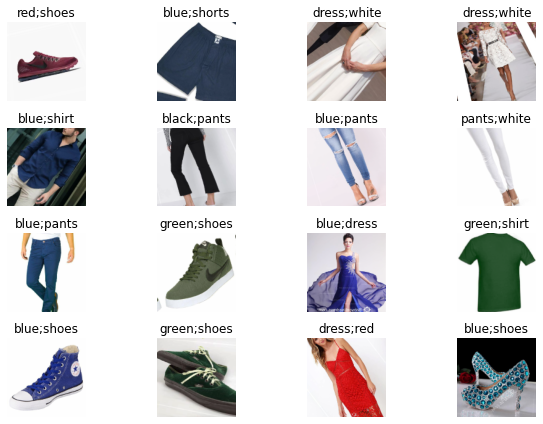

In [45]:
data.show_batch(rows=4, figsize=(9,6))

In [0]:
arch = models.resnet34

In [0]:
learn = cnn_learner(data, arch, metrics=[accuracy_thresh, fbeta])

In [0]:
learn.lr_find()

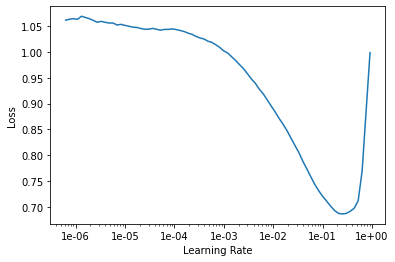

In [49]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [51]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.390102,0.100619,0.963492,0.915419,01:54
1,0.160915,0.060300,0.978568,0.951972,01:53
2,0.096587,0.048735,0.982858,0.963274,01:53
3,0.069851,0.038660,0.986490,0.970661,01:53
4,0.064219,0.038619,0.986756,0.970814,01:53
